# Main Code for DS2500 Project

In [153]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

## Data Preparation

First data file: dashboard data (no current information about closings, but it does have the latitude and longitude of each public beach in Massachusetts)

In [135]:
df = pd.read_excel('closings/BeachDashboardData-09-05.xlsx')
df = df[df["Marine or Freshwater"]=="Marine"]
public_beaches = list(df["Beach Name"])
public_beaches = [name.split(" -")[0].split(" (")[0].split(" @")[0].split(" Beach")[0] for name in public_beaches]

public_beaches[0:6]

['Lobsterville', 'Moshup', 'Philbin', 'Red', "Covell's", 'Craigville']

Second data file: shapefile of Masachusetts beaches (filtered to only the beaches in the dashboard data, since this file comes from the EPA, ie not all beaches in this file are public bathing beaches)

In [136]:
df = gpd.read_file("geodata/MARINEBEACHES_PT.shp")
df = df[["BEACHNAME", "LATITUDE", "LONGITUDE", "COUNTYNAME", "geometry"]]
df = df.rename(columns={"BEACHNAME": "Beach Name"})
df["Beach Name"] = [name.split(" -")[0].split(" (")[0].split(" @")[0].split(" Beach")[0] for name in df["Beach Name"]]
df = df.loc[[val in public_beaches for val in list(df["Beach Name"])]]
df = df.drop_duplicates("Beach Name")

df.head(5)

,Beach Name,LATITUDE,LONGITUDE,COUNTYNAME,geometry
0,Wollaston,42.266521,-70.996756,Norfolk,POINT (241518.014 890794.791)
59,Crocker Park,42.502692,-70.848354,Essex,POINT (253560.704 917110.151)
64,Tudor,42.423344,-70.918056,Essex,POINT (247891.904 908255.061)
85,Black Rock,42.430022,-70.934792,Essex,POINT (246509.694 908987.581)
93,Short,42.433719,-70.934575,Essex,POINT (246524.834 909398.271)


Example of the third data file: A csv of closed beaches along with the type of beach and the reason for closing

In [137]:
example = pd.read_csv(f'closings/BeachPostingTbl-07-05-23.csv')
example.head(5)

,Municipality,Beach,Beach Type,Posting Reason
0,Agawam,Robinson Pond Beach (DCR),Freshwater,Bacterial Exceedance
1,Ashby,Damon Pond Beach (DCR),Freshwater,Bacterial Exceedance
2,Athol,Ellis Beach,Freshwater,Bacterial Exceedance
3,Beverly,Dane Street - Bathhouse,Marine,Bacterial Exceedance
4,Beverly,Brackenbury,Marine,Bacterial Exceedance


## Feature Engineering: Beach Closings by Week

All files were read in and filtered to marine beaches closed for bacterial exceedance to give us a list of closed beaches for that day. The information was put into a matrix with the columns as dates (all in July) and the rows as True (beach was closed on that day) or False (beach was open on that day)

In [138]:
filenames = os.listdir("closings")[1:]

closings = pd.DataFrame()
for filename in filenames:
    beach = pd.read_csv(f'closings/{filename}')
    beach["Beach"] = [name.split(" -")[0].split(" (")[0].split(" @")[0].split(" Beach")[0] for name in beach["Beach"]]
    beach = beach[(beach["Posting Reason"]=="Bacterial Exceedance") & (beach["Beach Type"]=="Marine")]
    closed_beaches = list(beach["Beach"])

    date = filename.split("-")[2]

    closings[int(date)] = df['Beach Name'].apply(lambda x: x in closed_beaches)

closings.head(5)


,5,6,7,10,12,13,14,17,18,19,20,21,24,25,26,27
0,True,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False
59,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
64,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
85,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
93,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In order to turn this into features, we expressed these values as percent of the time that the beach was closed each week. For each week, we filtered the matrix of closings for only the days in those week, and calculated the percentage of time each beach was closed during that week. Then, we appended this to the dataframe of all beaches

In [139]:
calendar = {"W1 % Closed":range(1,9),
            "W2 % Closed":range(9,16),
            "W3 % Closed":range(16,23)}

for key, value in calendar.items():
    dates_in_week = [date for date in list(closings.columns) if date in value]
    filtered_df = closings[dates_in_week]
    total_closings = filtered_df.sum(axis=1)
    percent_closings = total_closings.apply(lambda x: x/len(dates_in_week))

    df[key]= percent_closings    

Histogram of beach closings - the majority of beaches were open, so if we were to use just this data by itself our model would likely overfit. However, we hope by incorperating location information (latitude and longitude) and weather information (rainfall), we can get a better model

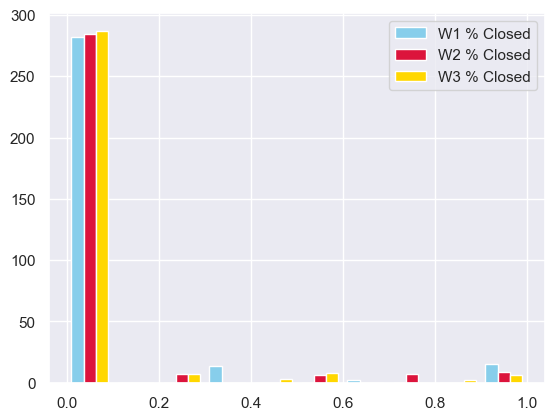

In [140]:
sns.set_theme()
plt.hist(df[["W1 % Closed", "W2 % Closed", "W3 % Closed"]], color=['skyblue','crimson','gold'], 
         label=["W1 % Closed", "W2 % Closed", "W3 % Closed"])
plt.legend()

## Feature Engineering: Total Rainfall

The OpenWeather API does not give access to any historical weather data, so I had to use the StormGlass API. However, this only allows for 10 calls per day, which is far too few for the amount of beaches in the dataset. So, for the weather data, I picked 8 cities along the different coastal zones in Massachussets and downloaded the weather data 

In [62]:
CITIES = ["Ipswich", "Beverly", "Boston", "Marshfield", "Barnstable", "Wellfleet", "New Bedford", "Edgartown"]
COORDINATES = [[42.6792, -70.8412],
               [42.5584, -70.8800],
               [42.3601, -71.0589],
               [42.0917, -70.7056],
               [41.7003, -70.3002],
               [41.9305, -70.0310],
               [41.6362, -70.9342],
               [41.3890, -70.5134]]

In [70]:
API_KEY = "02a656fa-8e37-11ee-8309-0242ac130002-02a657a4-8e37-11ee-8309-0242ac130002"
url = "https://api.stormglass.io/v2/weather/point"

total_precipitation = []
for coord in COORDINATES:
    params = {"lat" : coord[0],
              "lng" : coord[1],
              "params" : "precipitation",
              "start" : 1688270400,
              "end" : 1690084799}

    response = requests.get(url, params = params, headers={'Authorization': API_KEY})
    data = response.json()
    total_precipitation.append(sum([val["precipitation"]["noaa"] for val in data["hours"]]))

In [141]:
closest_precipitation = []
for beach in df[["LATITUDE","LONGITUDE"]].values.tolist():
    distances = [math.dist(c,beach) for c in COORDINATES]
    closest_precipitation.append(total_precipitation[distances.index(min(distances))])

df["Total Precipitation"]=closest_precipitation
df.head(5)

,Beach Name,LATITUDE,LONGITUDE,COUNTYNAME,geometry,W1 % Closed,W2 % Closed,W3 % Closed,Total Precipitation
0,Wollaston,42.266521,-70.996756,Norfolk,POINT (241518.014 890794.791),1.000000,0.0,0.2,44.23
59,Crocker Park,42.502692,-70.848354,Essex,POINT (253560.704 917110.151),0.000000,0.0,0.0,44.23
64,Tudor,42.423344,-70.918056,Essex,POINT (247891.904 908255.061),0.000000,0.0,0.0,44.23
85,Black Rock,42.430022,-70.934792,Essex,POINT (246509.694 908987.581),0.666667,0.0,0.0,44.23
93,Short,42.433719,-70.934575,Essex,POINT (246524.834 909398.271),0.333333,0.0,0.0,44.23


Add labels to dataframe

In [142]:
last_week = closings[[24,25,26,27]]
df["Closed in Last Week of July"] = [val != 0 for val in last_week.sum(axis=1)]

df.head(5)

,Beach Name,LATITUDE,LONGITUDE,COUNTYNAME,geometry,W1 % Closed,W2 % Closed,W3 % Closed,Total Precipitation,Closed in Last Week of July
0,Wollaston,42.266521,-70.996756,Norfolk,POINT (241518.014 890794.791),1.000000,0.0,0.2,44.23,True
59,Crocker Park,42.502692,-70.848354,Essex,POINT (253560.704 917110.151),0.000000,0.0,0.0,44.23,False
64,Tudor,42.423344,-70.918056,Essex,POINT (247891.904 908255.061),0.000000,0.0,0.0,44.23,False
85,Black Rock,42.430022,-70.934792,Essex,POINT (246509.694 908987.581),0.666667,0.0,0.0,44.23,False
93,Short,42.433719,-70.934575,Essex,POINT (246524.834 909398.271),0.333333,0.0,0.0,44.23,False


## Algorithm: KNN Classfier

In [147]:
features = df[["LATITUDE","LONGITUDE","W1 % Closed","W2 % Closed","W3 % Closed","Total Precipitation"]]
labels = list(df["Closed in Last Week of July"])

scaler = MinMaxScaler()
scaler.fit(features)
features = scaler.transform(features)

## Accuracy

In [169]:
# test the ks
ks = list(range(4,19))

accuracy_scores = []
for k in ks:
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=0)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(train_features, train_labels)
    kf = KFold(n_splits=4, random_state=0, shuffle=True)
    cv_scores = cross_val_score(knn, features, labels, cv=kf, scoring="accuracy")
    print(f'{k} neighbors: {np.mean(cv_scores)}')
    accuracy_scores.append(np.mean(cv_scores))

4 neighbors: 0.9520853618954885
5 neighbors: 0.9520447906523857
6 neighbors: 0.9584550470626421
7 neighbors: 0.9552499188575139
8 neighbors: 0.9521259331385914
9 neighbors: 0.9521259331385914
10 neighbors: 0.9521259331385914
11 neighbors: 0.9521259331385914
12 neighbors: 0.945715676728335
13 neighbors: 0.9489208049334632
14 neighbors: 0.9489208049334632
15 neighbors: 0.9489208049334632
16 neighbors: 0.945715676728335
17 neighbors: 0.9521259331385914
18 neighbors: 0.945715676728335


In [171]:
print(f'Best k: {ks[accuracy_scores.index(max(accuracy_scores))]}')

Best k: 6


## Precision

In [172]:
# test the ks
ks = list(range(4,19))

precision_scores = []
for k in ks:
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=0)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(train_features, train_labels)
    kf = KFold(n_splits=4, random_state=0, shuffle=True)
    cv_scores = cross_val_score(knn, features, labels, cv=kf, scoring="precision")
    print(f'{k} neighbors: {np.mean(cv_scores)}')
    precision_scores.append(np.mean(cv_scores))

4 neighbors: 0.75
5 neighbors: 0.7083333333333334
6 neighbors: 0.875
7 neighbors: 0.75


c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8 neighbors: 0.625
9 neighbors: 0.625
10 neighbors: 0.625


c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\met

11 neighbors: 0.625
12 neighbors: 0.125
13 neighbors: 0.375
14 neighbors: 0.375


c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\met

15 neighbors: 0.375
16 neighbors: 0.0
17 neighbors: 0.5
18 neighbors: 0.0


c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tamar\anaconda3\envs\mass_beach\lib\site-packages\sklearn\met

In [173]:
print(f'Best k: {ks[precision_scores.index(max(precision_scores))]}')

Best k: 6


## Recall

In [174]:
# test the ks
ks = list(range(4,19))

recall_scores = []
for k in ks:
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=0)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(train_features, train_labels)
    kf = KFold(n_splits=4, random_state=0, shuffle=True)
    cv_scores = cross_val_score(knn, features, labels, cv=kf, scoring="recall")
    print(f'{k} neighbors: {np.mean(cv_scores)}')
    recall_scores.append(np.mean(cv_scores))

4 neighbors: 0.2791666666666667
5 neighbors: 0.32916666666666666
6 neighbors: 0.32916666666666666
7 neighbors: 0.32916666666666666
8 neighbors: 0.22916666666666666
9 neighbors: 0.22916666666666666
10 neighbors: 0.22916666666666666
11 neighbors: 0.22916666666666666
12 neighbors: 0.0625
13 neighbors: 0.1875
14 neighbors: 0.1875
15 neighbors: 0.1875
16 neighbors: 0.0
17 neighbors: 0.1875
18 neighbors: 0.0


In [175]:
print(f'Best k: {ks[recall_scores.index(max(recall_scores))]}')

Best k: 5


## Using the optimal k overall (6) to calculate the F1 Score

In [177]:
k = 6
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=0)
knn = KNeighborsClassifier(n_neighbors=k)
knn = knn.fit(train_features, train_labels)
predicted_to_close = knn.predict(test_features)

print(f'F1 score for beaches that closed: {round(metrics.f1_score(test_labels, predicted_to_close), 4)}')

F1 score for beaches that closed: 0.5714


## Confusion Matrix

[[74  0]
 [ 3  2]]


<Axes: >

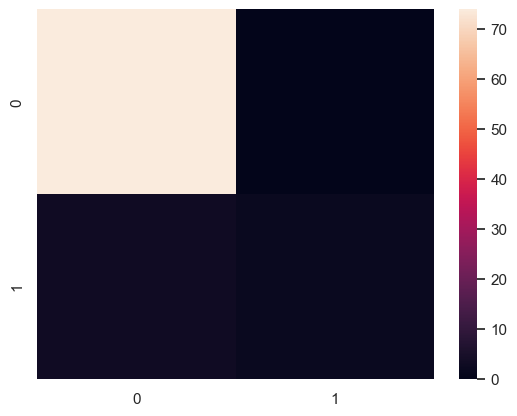

In [181]:
k = 6
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=0)
knn = KNeighborsClassifier(n_neighbors=k)
knn = knn.fit(train_features, train_labels)
predictions = knn.predict(test_features)
mat = metrics.confusion_matrix(test_labels,predictions)

print(mat)
sns.heatmap(mat)

## Summary Plot of Accuracy, Precision, and Recall

In [182]:
plt_dat = pd.DataFrame(zip(accuracy_scores, precision_scores, recall_scores), columns=["Accuracy", "Precision", "Recall"], index=ks)

[Text(0.5, 0, 'k'), Text(0, 0.5, 'Score')]

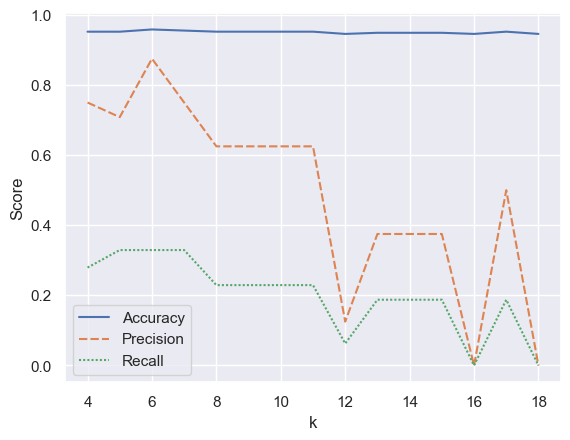

In [183]:
sns.lineplot(plt_dat).set(xlabel='k', ylabel='Score')